**Instalasi PySpark**

In [ ]:
pip install pyspark

**Membaca Data Inflasi**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id

# Membuat Spark session
spark = SparkSession.builder.appName("RenameColumnsAndDropTop3Rows").getOrCreate()

# Membaca file CSV
df = spark.read.csv("/UTS_BD/Inflasi Tahunan.csv", header=True, inferSchema=True)

# Menambahkan indeks baris
df_with_index = df.withColumn("index", monotonically_increasing_id())

# Menghapus 3 baris teratas berdasarkan indeks
df_filtered = df_with_index.filter(df_with_index["index"] > 2).drop("index")

# Mengganti nama kolom dari kolom kedua hingga kesembilan menjadi Januari-September
new_column_names = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September']
old_column_names = df_filtered.columns[1:len(new_column_names) + 1]  # Kolom yang akan diganti (mulai dari kolom kedua)

# Ganti nama kolom kedua hingga kesembilan
for old_name, new_name in zip(old_column_names, new_column_names):
    df_filtered = df_filtered.withColumnRenamed(old_name, new_name)

# Menampilkan hasil
df_filtered.show(40)

# Menyimpan hasil ke file baru dengan mode overwrite
df_filtered.write.mode("overwrite").csv("/UTS_BD/Data Bersih", header=True)


+----------------------+-------+--------+-----+-----+----+----+----+-------+---------+
|38 Provinsi (2022=100)|Januari|Februari|Maret|April| Mei|Juni|Juli|Agustus|September|
+----------------------+-------+--------+-----+-----+----+----+----+-------+---------+
|             PROV ACEH|   2.12|    2.33| 3.25| 3.14|3.32|3.09|2.51|   2.29|      1.5|
|   PROV SUMATERA UTARA|   2.16|     2.5| 3.67| 3.96|4.26|3.35|2.06|   1.86|      1.4|
|   PROV SUMATERA BARAT|   2.57|    3.32| 3.93| 3.81|4.17|4.04|2.44|   2.22|     1.52|
|             PROV RIAU|   2.35|    2.86| 3.57| 3.99|4.41|3.56|2.22|   1.99|     1.38|
|            PROV JAMBI|   2.99|    3.19| 3.84| 3.93|3.55|3.34|2.14|    2.5|     1.95|
|  PROV SUMATERA SEL...|   3.35|    3.15| 3.24| 3.12|2.98|2.48|1.87|    1.8|      1.4|
|         PROV BENGKULU|   2.83|    3.68| 3.56| 3.62|3.71|3.64|2.31|   2.34|     1.48|
|          PROV LAMPUNG|   3.28|    3.28| 3.45| 3.29|3.09|2.84|2.55|   2.33|     2.16|
|  PROV KEPULAUAN BA...|   1.21|    1.86|  

 **Data Cleaning**


Memisahkan data Indonesia dari data seluruh provinsi

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Membuat Spark session
spark = SparkSession.builder.appName("RemoveIndonesiaRows").getOrCreate()

# Membaca file CSV
df = spark.read.csv("/UTS_BD/Data Bersih/part-00000-aabc3745-b589-4305-8511-33681d15097e-c000.csv", header=True, inferSchema=True)

# Menampilkan nama kolom yang ada pada DataFrame
print("Nama kolom yang ada dalam DataFrame:")
print(df.columns)

# Misalkan kolom yang ingin Anda filter adalah '38 Provinsi (2022=100)' (sesuaikan dengan nama kolom yang benar)
# Gantilah dengan nama kolom yang sesuai dari hasil output `df.columns`
df_filtered = df.filter(col("38 Provinsi (2022=100)") != "INDONESIA")

# Menampilkan DataFrame setelah menghapus baris
print("DataFrame Setelah Menghapus Baris yang Mengandung 'INDONESIA':")
df_filtered.show(40)

# Menyimpan hasil ke file CSV baru dengan mode overwrite
df_filtered.write.mode("overwrite").csv("/UTS_BD/Data Tanpa Indonesia ", header=True)

# Menutup Spark session
spark.stop()


Nama kolom yang ada dalam DataFrame:
['38 Provinsi (2022=100)', 'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September']
DataFrame Setelah Menghapus Baris yang Mengandung 'INDONESIA':
+----------------------+-------+--------+-----+-----+----+----+----+-------+---------+
|38 Provinsi (2022=100)|Januari|Februari|Maret|April| Mei|Juni|Juli|Agustus|September|
+----------------------+-------+--------+-----+-----+----+----+----+-------+---------+
|             PROV ACEH|   2.12|    2.33| 3.25| 3.14|3.32|3.09|2.51|   2.29|      1.5|
|   PROV SUMATERA UTARA|   2.16|     2.5| 3.67| 3.96|4.26|3.35|2.06|   1.86|      1.4|
|   PROV SUMATERA BARAT|   2.57|    3.32| 3.93| 3.81|4.17|4.04|2.44|   2.22|     1.52|
|             PROV RIAU|   2.35|    2.86| 3.57| 3.99|4.41|3.56|2.22|   1.99|     1.38|
|            PROV JAMBI|   2.99|    3.19| 3.84| 3.93|3.55|3.34|2.14|    2.5|     1.95|
|  PROV SUMATERA SEL...|   3.35|    3.15| 3.24| 3.12|2.98|2.48|1.87|    1.8|      1.4|
| 

Memisahkan data per provinsi agar bisa menjadi 38 csv sesuai dengan banyaknya provinsi di Indonesia

In [ ]:
from pyspark.sql import SparkSession
import os
import shutil

# Buat SparkSession
spark = SparkSession.builder.appName("SplitCSVRows").getOrCreate()

# Path ke file CSV yang akan diproses
input_csv_path = "/UTS_BD/Data non Indonesia /File Non IDN.csv"

# Baca CSV ke DataFrame
df = spark.read.option("header", "true").csv(input_csv_path)

# Folder tempat CSV input berada
output_folder = os.path.dirname(input_csv_path)

# Fungsi untuk memisahkan setiap baris ke file CSV terpisah
def save_row_to_csv(row, columns):
    row_id = row[0]  # Ambil teks dari kolom pertama sebagai nama file
    # Ganti karakter yang tidak valid untuk nama file (jika ada)
    row_id = ''.join(e for e in row_id if e.isalnum() or e in (' ', '_')).strip()

    # Tentukan jalur output file CSV
    output_file = os.path.join(output_folder, f"{row_id}.csv")

    # Buat DataFrame dari baris
    single_row_df = spark.createDataFrame([row], columns)

    # Tentukan jalur sementara untuk output karena Spark selalu membuat folder
    temp_output_path = os.path.join(output_folder, f"temp_{row_id}")

    # Simpan ke jalur sementara
    single_row_df.coalesce(1).write.csv(temp_output_path, header=True, mode='overwrite')

    # Pindahkan file dari folder sementara ke file CSV secara langsung
    for filename in os.listdir(temp_output_path):
        if filename.endswith(".csv"):
            shutil.move(os.path.join(temp_output_path, filename), output_file)

    # Hapus folder sementara
    shutil.rmtree(temp_output_path)

# Ambil nama kolom dari DataFrame
columns = df.columns

# Loop setiap baris dan panggil fungsi untuk menyimpan sebagai CSV
for row in df.collect():
    save_row_to_csv(row, columns)

# Hentikan SparkSession setelah selesai
spark.stop()


**Compare Mean Inflation Rates**

Membuat perbandingan rata-rata antara data inflasi provinsi dengan data inflasi Indonesia (Nasional)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, format_number

# Membuat Spark session
spark = SparkSession.builder.appName("AverageMonthlyInflation").getOrCreate()

# Membaca file CSV
df = spark.read.csv("/UTS_BD/Data non Indonesia /File Non IDN.csv", header=True, inferSchema=True)
df_indo = spark.read.csv("/UTS_BD/Data Pisah/Pisah Indonesia.csv", header=True, inferSchema=True)

# Menampilkan nama kolom yang ada pada DataFrame (untuk memeriksa kolom yang relevan)
print("Nama kolom yang ada dalam DataFrame:")
print(df.columns)

# Menghitung rata-rata inflasi per bulan untuk seluruh provinsi
mean_inflasi_bulanan = df.select(
    format_number(avg("Januari"), 3).alias("Avg_Januari"),
    format_number(avg("Februari"), 3).alias("Avg_Februari"),
    format_number(avg("Maret"), 3).alias("Avg_Maret"),
    format_number(avg("April"), 3).alias("Avg_April"),
    format_number(avg("Mei"), 3).alias("Avg_Mei"),
    format_number(avg("Juni"), 3).alias("Avg_Juni"),
    format_number(avg("Juli"), 3).alias("Avg_Juli"),
    format_number(avg("Agustus"), 3).alias("Avg_Agustus"),
    format_number(avg("September"), 3).alias("Avg_September")
)

# Menampilkan rata-rata inflasi per bulan untuk seluruh provinsi
print("Rata-rata inflasi per bulan untuk seluruh provinsi:")
mean_inflasi_bulanan.show()

print("Menampilkan beberapa baris dari DataFrame:")
df_indo.show()

# Menyimpan hasil rata-rata bulanan ke file CSV baru dengan mode overwrite
mean_inflasi_bulanan.write.mode("overwrite").csv("/UTS_BD/Data Rata-rata Inflasi Bulanan", header=True)

# Menutup Spark session
spark.stop()


Nama kolom yang ada dalam DataFrame:
['38 Provinsi (2022=100)', 'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September']
Rata-rata inflasi per bulan untuk seluruh provinsi:
+-----------+------------+---------+---------+-------+--------+--------+-----------+-------------+
|Avg_Januari|Avg_Februari|Avg_Maret|Avg_April|Avg_Mei|Avg_Juni|Avg_Juli|Avg_Agustus|Avg_September|
+-----------+------------+---------+---------+-------+--------+--------+-----------+-------------+
|      2.881|       2.904|    3.139|    3.133|  3.136|   2.808|   2.245|      2.192|        2.001|
+-----------+------------+---------+---------+-------+--------+--------+-----------+-------------+

Menampilkan beberapa baris dari DataFrame:
+----------------------+-------+--------+-----+-----+----+----+----+-------+---------+
|38 Provinsi (2022=100)|Januari|Februari|Maret|April| Mei|Juni|Juli|Agustus|September|
+----------------------+-------+--------+-----+-----+----+----+----+-------+-------

**Calculation of Differences**

Melakukan perbandingan selisih absolute dari rata-rata inflasi provinsi dan inflasi nasional pada setiap bulannya

Nama kolom yang ada dalam DataFrame:
['38 Provinsi (2022=100)', 'Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September']
Rata-rata inflasi per bulan untuk seluruh provinsi:
+-----------+------------+---------+---------+-------+--------+--------+-----------+-------------+
|Avg_Januari|Avg_Februari|Avg_Maret|Avg_April|Avg_Mei|Avg_Juni|Avg_Juli|Avg_Agustus|Avg_September|
+-----------+------------+---------+---------+-------+--------+--------+-----------+-------------+
|      2.881|       2.904|    3.139|    3.133|  3.136|   2.808|   2.245|      2.192|        2.001|
+-----------+------------+---------+---------+-------+--------+--------+-----------+-------------+

Menampilkan beberapa baris dari DataFrame Indonesia:
+----------------------+-------+--------+-----+-----+----+----+----+-------+---------+
|38 Provinsi (2022=100)|Januari|Februari|Maret|April| Mei|Juni|Juli|Agustus|September|
+----------------------+-------+--------+-----+-----+----+----+----+-----

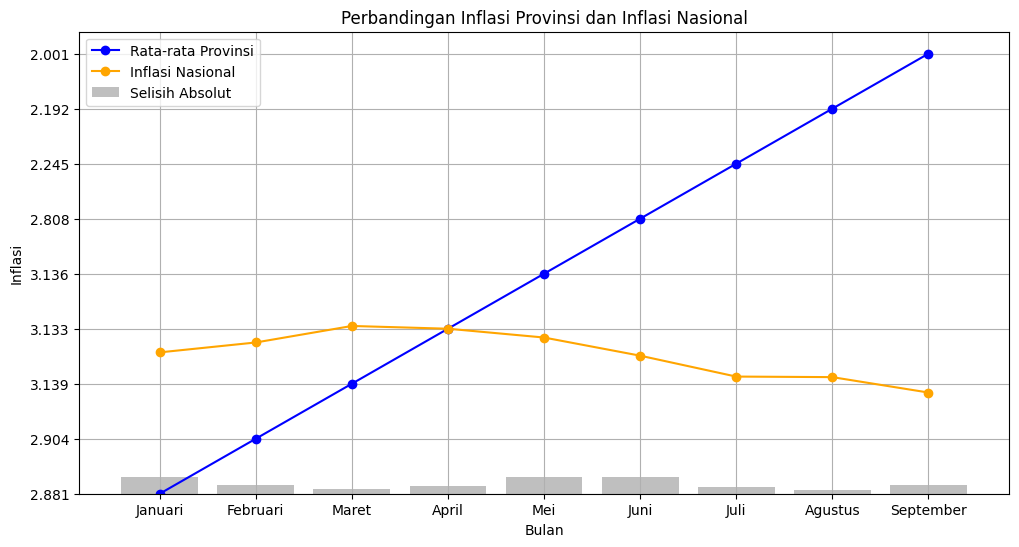

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, format_number, abs, col
import pandas as pd
import matplotlib.pyplot as plt

# Membuat Spark session
spark = SparkSession.builder.appName("AverageMonthlyInflation").getOrCreate()

# Membaca file CSV
df = spark.read.csv("/UTS_BD/Data non Indonesia /File Non IDN.csv", header=True, inferSchema=True)
df_indo = spark.read.csv("/UTS_BD/Data Pisah/Pisah Indonesia.csv", header=True, inferSchema=True)

# Menampilkan nama kolom yang ada pada DataFrame (untuk memeriksa kolom yang relevan)
print("Nama kolom yang ada dalam DataFrame:")
print(df.columns)

# Menghitung rata-rata inflasi per bulan untuk seluruh provinsi
mean_inflasi_bulanan = df.select(
    format_number(avg("Januari"), 3).alias("Avg_Januari"),
    format_number(avg("Februari"), 3).alias("Avg_Februari"),
    format_number(avg("Maret"), 3).alias("Avg_Maret"),
    format_number(avg("April"), 3).alias("Avg_April"),
    format_number(avg("Mei"), 3).alias("Avg_Mei"),
    format_number(avg("Juni"), 3).alias("Avg_Juni"),
    format_number(avg("Juli"), 3).alias("Avg_Juli"),
    format_number(avg("Agustus"), 3).alias("Avg_Agustus"),
    format_number(avg("September"), 3).alias("Avg_September")
)

# Menampilkan rata-rata inflasi per bulan untuk seluruh provinsi
print("Rata-rata inflasi per bulan untuk seluruh provinsi:")
mean_inflasi_bulanan.show()

print("Menampilkan beberapa baris dari DataFrame Indonesia:")
df_indo.show()

# Mengambil inflasi Indonesia dari df_indo
indonesia_values = df_indo.first()

# Menghitung selisih absolut antara inflasi provinsi dan inflasi nasional
result_df = mean_inflasi_bulanan.select(
    col("Avg_Januari"),
    abs(col("Avg_Januari") - float(indonesia_values["Januari"])).alias("Difference_Januari"),
    col("Avg_Februari"),
    abs(col("Avg_Februari") - float(indonesia_values["Februari"])).alias("Difference_Februari"),
    col("Avg_Maret"),
    abs(col("Avg_Maret") - float(indonesia_values["Maret"])).alias("Difference_Maret"),
    col("Avg_April"),
    abs(col("Avg_April") - float(indonesia_values["April"])).alias("Difference_April"),
    col("Avg_Mei"),
    abs(col("Avg_Mei") - float(indonesia_values["Mei"])).alias("Difference_Mei"),
    col("Avg_Juni"),
    abs(col("Avg_Juni") - float(indonesia_values["Juni"])).alias("Difference_Juni"),
    col("Avg_Juli"),
    abs(col("Avg_Juli") - float(indonesia_values["Juli"])).alias("Difference_Juli"),
    col("Avg_Agustus"),
    abs(col("Avg_Agustus") - float(indonesia_values["Agustus"])).alias("Difference_Agustus"),
    col("Avg_September"),
    abs(col("Avg_September") - float(indonesia_values["September"])).alias("Difference_September")
)

# Menampilkan hasil selisih absolut
print("Perbandingan inflasi provinsi dan selisih absolut dengan inflasi nasional:")
result_df.show()

# Mengonversi DataFrame PySpark ke DataFrame Pandas untuk plotting
result_pd = result_df.toPandas()

# Plotting
months = ["Januari", "Februari", "Maret", "April", "Mei", "Juni", "Juli", "Agustus", "September"]
avg_columns = [f"Avg_{month}" for month in months]
diff_columns = [f"Difference_{month}" for month in months]

# Mengatur ukuran grafik
plt.figure(figsize=(12, 6))

# Plotting rata-rata inflasi provinsi
plt.plot(months, result_pd[avg_columns].iloc[0], marker='o', label='Rata-rata Provinsi', color='blue')
# Plotting inflasi nasional
plt.plot(months, [float(indonesia_values[month]) for month in months], marker='o', label='Inflasi Nasional', color='orange')

# Plotting selisih absolut
plt.bar(months, result_pd[diff_columns].iloc[0], alpha=0.5, label='Selisih Absolut', color='gray')

# Menambahkan label dan judul
plt.title('Perbandingan Inflasi Provinsi dan Inflasi Nasional')
plt.xlabel('Bulan')
plt.ylabel('Inflasi')
plt.legend()
plt.grid()

# Menampilkan grafik
plt.show()

# Menyimpan hasil rata-rata bulanan dan perbandingan ke file CSV baru dengan mode overwrite
result_df.write.mode("overwrite").csv("/UTS_BD/Data Perbandingan Inflasi", header=True)

# Menutup Spark session
spark.stop()


**Analysis**

Investigate Discrepancies

Menganalisa bagaimana proses laju inflasi nasional dengan rata-rata laju inflasi provinsi

Investigasi Discrepancies:
+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+
|       Avg_Januari|     Avg_Februari|        Avg_Maret|         Avg_April|           Avg_Mei|          Avg_Juni|         Avg_Juli|      Avg_Agustus|     Avg_September|       Diff_Januari|      Diff_Februari|         Diff_Maret|         Diff_April|           Diff_Mei|          Diff_Juni|          Diff_Juli|        Diff_Agustus|     Diff_September|
+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-----

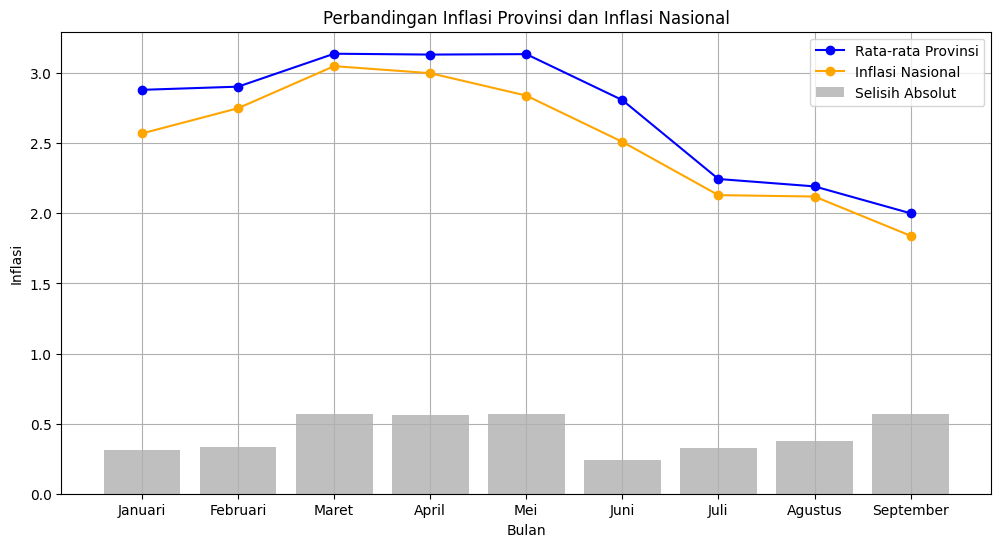

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, abs
import pandas as pd
import matplotlib.pyplot as plt

# Membuat Spark session
spark = SparkSession.builder.appName("InvestigateDiscrepancies").getOrCreate()

# Membaca file CSV
df = spark.read.csv("/UTS_BD/Data non Indonesia /File Non IDN.csv", header=True, inferSchema=True)
df_indo = spark.read.csv("/UTS_BD/Data Pisah/Pisah Indonesia.csv", header=True, inferSchema=True)

# Menghitung rata-rata inflasi per bulan untuk seluruh provinsi
mean_inflasi_bulanan = df.select(
    avg("Januari").alias("Avg_Januari"),
    avg("Februari").alias("Avg_Februari"),
    avg("Maret").alias("Avg_Maret"),
    avg("April").alias("Avg_April"),
    avg("Mei").alias("Avg_Mei"),
    avg("Juni").alias("Avg_Juni"),
    avg("Juli").alias("Avg_Juli"),
    avg("Agustus").alias("Avg_Agustus"),
    avg("September").alias("Avg_September")
)

# Mengambil inflasi Indonesia dari df_indo
indonesia_values = df_indo.first()

# Membuat DataFrame dari nilai inflasi nasional
mean_inflasi_nasional = spark.createDataFrame([(float(indonesia_values["Januari"]),),
                                                 (float(indonesia_values["Februari"]),),
                                                 (float(indonesia_values["Maret"]),),
                                                 (float(indonesia_values["April"]),),
                                                 (float(indonesia_values["Mei"]),),
                                                 (float(indonesia_values["Juni"]),),
                                                 (float(indonesia_values["Juli"]),),
                                                 (float(indonesia_values["Agustus"]),),
                                                 (float(indonesia_values["September"]),)],
                                                ["National_Avg"])

# Menghitung perbedaan antara rata-rata inflasi provinsi dan nasional
diff_df = mean_inflasi_bulanan.crossJoin(mean_inflasi_nasional)

discrepancies = diff_df.select(
    col("Avg_Januari"), col("Avg_Februari"), col("Avg_Maret"),
    col("Avg_April"), col("Avg_Mei"), col("Avg_Juni"),
    col("Avg_Juli"), col("Avg_Agustus"), col("Avg_September"),
    abs(col("Avg_Januari") - col("National_Avg")).alias("Diff_Januari"),
    abs(col("Avg_Februari") - col("National_Avg")).alias("Diff_Februari"),
    abs(col("Avg_Maret") - col("National_Avg")).alias("Diff_Maret"),
    abs(col("Avg_April") - col("National_Avg")).alias("Diff_April"),
    abs(col("Avg_Mei") - col("National_Avg")).alias("Diff_Mei"),
    abs(col("Avg_Juni") - col("National_Avg")).alias("Diff_Juni"),
    abs(col("Avg_Juli") - col("National_Avg")).alias("Diff_Juli"),
    abs(col("Avg_Agustus") - col("National_Avg")).alias("Diff_Agustus"),
    abs(col("Avg_September") - col("National_Avg")).alias("Diff_September")
)

# Menampilkan hasil analisis
print("Investigasi Discrepancies:")
discrepancies.show()

# Mengonversi DataFrame PySpark ke DataFrame Pandas untuk plotting
discrepancies_pd = discrepancies.toPandas()

# Data untuk plotting
months = ["Januari", "Februari", "Maret", "April", "Mei", "Juni", "Juli", "Agustus", "September"]
avg_columns = [f"Avg_{month}" for month in months]
diff_columns = [f"Diff_{month}" for month in months]

# Mengatur ukuran grafik
plt.figure(figsize=(12, 6))

# Plotting rata-rata inflasi provinsi
plt.plot(months, discrepancies_pd[avg_columns].iloc[0], marker='o', label='Rata-rata Provinsi', color='blue')
# Plotting inflasi nasional
plt.plot(months, [float(indonesia_values[month]) for month in months], marker='o', label='Inflasi Nasional', color='orange')

# Plotting selisih absolut
plt.bar(months, discrepancies_pd[diff_columns].iloc[0], alpha=0.5, label='Selisih Absolut', color='gray')

# Menambahkan label dan judul
plt.title('Perbandingan Inflasi Provinsi dan Inflasi Nasional')
plt.xlabel('Bulan')
plt.ylabel('Inflasi')
plt.legend()
plt.grid()

# Menampilkan grafik
plt.show()

# Menutup Spark session
spark.stop()


Mengidentifikasi pola (anomali) yang berada dalam data inflasi dari waktu ke waktu

Rata-rata dan Deviasi Standar per Bulan:
Januari: Avg = 2.881, StdDev = 0.844, Lower Bound = 1.193, Upper Bound = 4.569
Februari: Avg = 2.904, StdDev = 0.581, Lower Bound = 1.741, Upper Bound = 4.067
Maret: Avg = 3.139, StdDev = 0.719, Lower Bound = 1.701, Upper Bound = 4.577
April: Avg = 3.133, StdDev = 0.687, Lower Bound = 1.759, Upper Bound = 4.507
Mei: Avg = 3.136, StdDev = 0.932, Lower Bound = 1.272, Upper Bound = 4.999
Juni: Avg = 2.808, StdDev = 0.953, Lower Bound = 0.901, Upper Bound = 4.715
Juli: Avg = 2.245, StdDev = 0.855, Lower Bound = 0.535, Upper Bound = 3.955
Agustus: Avg = 2.192, StdDev = 0.808, Lower Bound = 0.576, Upper Bound = 3.809
September: Avg = 2.001, StdDev = 0.808, Lower Bound = 0.385, Upper Bound = 3.616

Detected Anomalies:
Empty DataFrame
Columns: [Month, National_Inflation, Lower_Bound, Upper_Bound]
Index: []


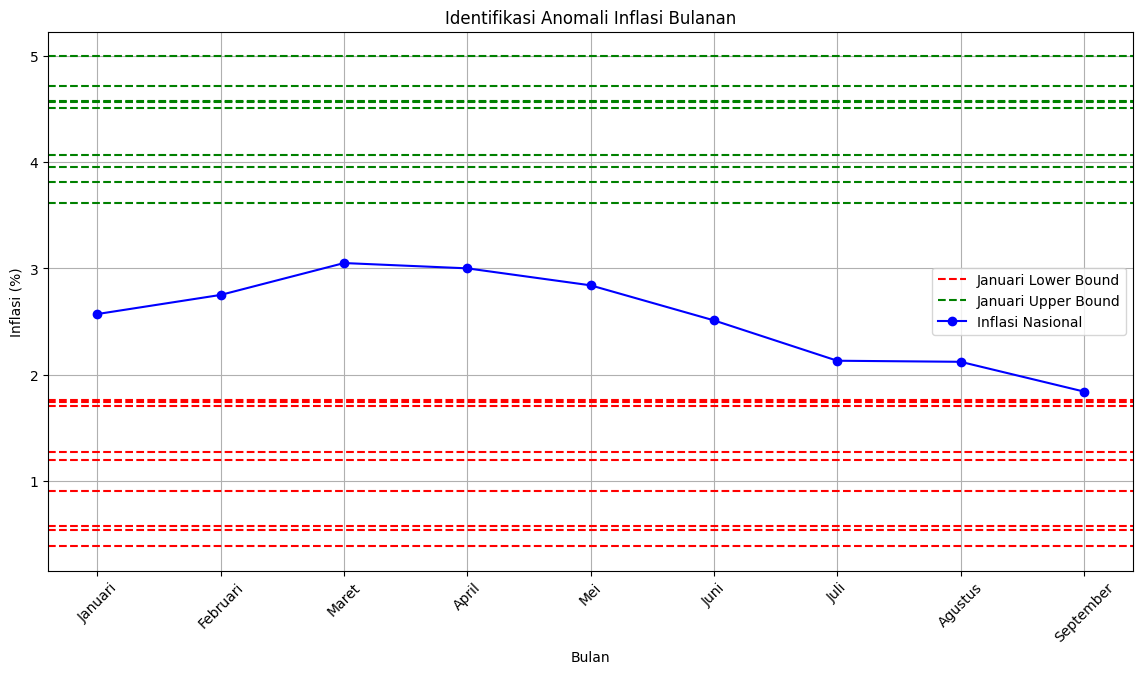

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev, col
import pandas as pd
import matplotlib.pyplot as plt

# Membuat Spark session
spark = SparkSession.builder.appName("IdentifyAnomalies").getOrCreate()

# Membaca file CSV
df = spark.read.csv("/UTS_BD/Data non Indonesia /File Non IDN.csv", header=True, inferSchema=True)
df_indo = spark.read.csv("/UTS_BD/Data Pisah/Pisah Indonesia.csv", header=True, inferSchema=True)

# Menghitung rata-rata dan deviasi standar inflasi per bulan untuk seluruh provinsi
stats_df = df.select(
    avg("Januari").alias("Avg_Januari"),
    stddev("Januari").alias("StdDev_Januari"),
    avg("Februari").alias("Avg_Februari"),
    stddev("Februari").alias("StdDev_Februari"),
    avg("Maret").alias("Avg_Maret"),
    stddev("Maret").alias("StdDev_Maret"),
    avg("April").alias("Avg_April"),
    stddev("April").alias("StdDev_April"),
    avg("Mei").alias("Avg_Mei"),
    stddev("Mei").alias("StdDev_Mei"),
    avg("Juni").alias("Avg_Juni"),
    stddev("Juni").alias("StdDev_Juni"),
    avg("Juli").alias("Avg_Juli"),
    stddev("Juli").alias("StdDev_Juli"),
    avg("Agustus").alias("Avg_Agustus"),
    stddev("Agustus").alias("StdDev_Agustus"),
    avg("September").alias("Avg_September"),
    stddev("September").alias("StdDev_September")
).first()

# Mengambil inflasi Indonesia dari df_indo
indonesia_values = df_indo.first()

# Membuat DataFrame dari nilai inflasi nasional
national_avg = [float(indonesia_values["Januari"]),
                float(indonesia_values["Februari"]),
                float(indonesia_values["Maret"]),
                float(indonesia_values["April"]),
                float(indonesia_values["Mei"]),
                float(indonesia_values["Juni"]),
                float(indonesia_values["Juli"]),
                float(indonesia_values["Agustus"]),
                float(indonesia_values["September"])]

# Mendefinisikan bulan
months = ["Januari", "Februari", "Maret", "April", "Mei", "Juni", "Juli", "Agustus", "September"]

# Mengatur ambang batas anomali (2 deviasi standar)
anomalies = {}
detected_anomalies = []

print("Rata-rata dan Deviasi Standar per Bulan:")
for i, month in enumerate(months):
    avg_value = stats_df[i * 2]
    std_dev_value = stats_df[i * 2 + 1]
    lower_bound = avg_value - 2 * std_dev_value
    upper_bound = avg_value + 2 * std_dev_value
    anomalies[month] = (lower_bound, upper_bound)
    print(f"{month}: Avg = {avg_value:.3f}, StdDev = {std_dev_value:.3f}, Lower Bound = {lower_bound:.3f}, Upper Bound = {upper_bound:.3f}")

    # Memeriksa apakah inflasi nasional berada di luar batas
    if national_avg[i] < lower_bound or national_avg[i] > upper_bound:
        detected_anomalies.append((month, national_avg[i], lower_bound, upper_bound))

# Menyimpan hasil anomali dalam DataFrame untuk visualisasi
anomalies_df = pd.DataFrame(detected_anomalies, columns=['Month', 'National_Inflation', 'Lower_Bound', 'Upper_Bound'])

# Menampilkan anomali
print("\nDetected Anomalies:")
print(anomalies_df)

# Visualisasi
plt.figure(figsize=(14, 7))

# Menggambar ambang batas untuk setiap bulan
for month in months:
    plt.axhline(y=anomalies[month][0], color='red', linestyle='--', label=f'{month} Lower Bound' if month == months[0] else "")
    plt.axhline(y=anomalies[month][1], color='green', linestyle='--', label=f'{month} Upper Bound' if month == months[0] else "")

# Menggambar inflasi nasional
plt.plot(months, national_avg, marker='o', label='Inflasi Nasional', color='blue')

# Menandai anomali di grafik
for anomaly in detected_anomalies:
    plt.plot(anomaly[0], anomaly[1], marker='o', color='red', markersize=10, label='Anomaly' if anomaly[0] == detected_anomalies[0][0] else "")

# Menambahkan label dan judul
plt.title('Identifikasi Anomali Inflasi Bulanan')
plt.xlabel('Bulan')
plt.ylabel('Inflasi (%)')
plt.xticks(rotation=45)
plt.grid()
plt.legend()

# Menampilkan grafik
plt.show()

# Menutup Spark session
spark.stop()


**Kesimpulan**

Berbagai faktor, seperti pengaruh musim, kebijakan ekonomi daerah, variasi dalam struktur ekonomi, metode penghitungan yang berbeda, akurasi data, dampak global, dan kondisi sosial, dapat menyebabkan perbedaan antara inflasi di tingkat provinsi dan inflasi nasional. Ini menjelaskan mengapa angka inflasi di masing-masing provinsi bisa berbeda dari angka yang dihitung secara nasional.